### **Imports and Configurations:**

In [1]:
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from joblib import dump

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Constants
from scripts.configs import SET_PALETTE, CON_CMAP
from scripts.configs import NON_GENRE_COLS, GENRE_COLS
from scripts.configs import NUMERICAL_COLS, LABEL_ENC_COLS

In [2]:
warnings.filterwarnings('ignore')
SET_PALETTE()

### **Loading Data:**

In [3]:
movie_df = pd.read_csv("./data/movies_data.csv").rename(columns={'Unnamed: 0': 'ID'})

movie_df['original_language'] = movie_df['original_language'].astype('category')
movie_df['status'] = movie_df['status'].astype('category')
movie_df['actor_name_1'] = movie_df['actor_name_1'].astype('category')
movie_df['actor_name_2'] = movie_df['actor_name_2'].astype('category')
movie_df['actor_name_3'] = movie_df['actor_name_3'].astype('category')
movie_df['actor_name_4'] = movie_df['actor_name_4'].astype('category')
movie_df['actor_name_5'] = movie_df['actor_name_5'].astype('category')
movie_df['production_company_name'] = movie_df['production_company_name'].astype('category')

### **Target Definition:**

In [4]:
movie_df['profitable'] = movie_df['profit_rate'].apply(lambda x: True if x > 1 else False)

### **Feature Scaling and Normalization:**

#### Normalizing Numerical Features:

In [5]:
normalizer = StandardScaler()
numeric_cols = ['revenue'] + NUMERICAL_COLS
movie_df[numeric_cols] = normalizer.fit_transform(movie_df[numeric_cols])

dump(normalizer, './models/numerical_scaler.joblib')

['./models/numerical_scaler.joblib']

#### Scaling Label-Encoded Features:

In [6]:
scaler = MinMaxScaler()

movie_df[LABEL_ENC_COLS] = scaler.fit_transform(movie_df[LABEL_ENC_COLS])

dump(scaler, './models/label_scaler.joblib')

['./models/label_scaler.joblib']

### **Feature Extraction:**

#### Genres:

In [7]:
pca = PCA(n_components=5)

principal_components = pca.fit_transform(movie_df[GENRE_COLS])

dump(pca, './models/genre_pca.joblib')

principalDf = pd.DataFrame(data=principal_components, columns=[f'genrePC{i+1}' for i in range(5)])

### **Feature Selection:**

In [8]:
x = movie_df[NON_GENRE_COLS]
y = movie_df['profitable']

selector = SelectKBest(f_classif, k=10)
X_new = selector.fit_transform(x, y)

cols = selector.get_support(indices=True)
selected_features_df = x.iloc[:,cols]

dump(selector, './models/feature_selector.joblib')
print(cols)

[ 0  1  3  4  7  9 10 12 13 15]


### **Mixing All Features Together:**

In [9]:
final_df = pd.concat([selected_features_df, principalDf , movie_df['profitable']], axis=1)
final_df.columns

Index(['runtime', 'budget', 'popularity', 'language_code', 'month', 'year',
       'vote_average', 'vote_count', 'actor_5_code', 'production_company_code',
       'genrePC1', 'genrePC2', 'genrePC3', 'genrePC4', 'genrePC5',
       'profitable'],
      dtype='object')

In [10]:
for col in list(sorted(final_df.columns)):
    print(col)

actor_5_code
budget
genrePC1
genrePC2
genrePC3
genrePC4
genrePC5
language_code
month
popularity
production_company_code
profitable
runtime
vote_average
vote_count
year


### **Modeling:**

#### Prepare train/test sets:

In [11]:
target = 'profitable'
features = [col for col in final_df.columns if col != target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(final_df[features], final_df[target], test_size=0.2, random_state=42)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

#### Logistic Regression:

              precision    recall  f1-score   support

           0       0.74      0.86      0.79       412
           1       0.86      0.74      0.80       492

    accuracy                           0.80       904
   macro avg       0.80      0.80      0.80       904
weighted avg       0.81      0.80      0.80       904



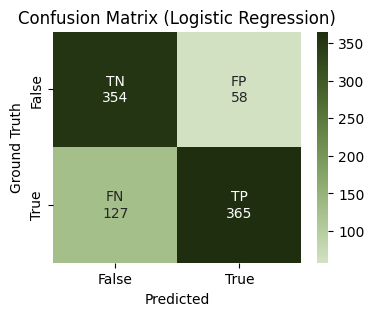

In [12]:
# Initialize the Logistic Regression model
LR_model = LogisticRegression()

# Fit the LR_model on the training data
LR_model.fit(X_train, y_train)

# Make predictions on the testing data
predictions = LR_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, predictions))

conf_matrix = confusion_matrix(y_test, predictions)

labels = ['TN', 'FP', 'FN', 'TP']
labels = np.asarray(labels).reshape(2,2)

labels_val = (np.asarray(["{0}\n{1}".format(label, val) for label, val in zip(labels.flatten(), conf_matrix.flatten())])).reshape(2,2)

plt.figure(figsize=(4,3))
sns.heatmap(conf_matrix, annot=labels_val, fmt='', cmap=CON_CMAP)
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix (Logistic Regression)")

plt.xticks([0.5, 1.5], ['False', 'True'])
plt.yticks([0.5, 1.5], ['False', 'True'])

plt.show()

##### ROC-AUC Plot:

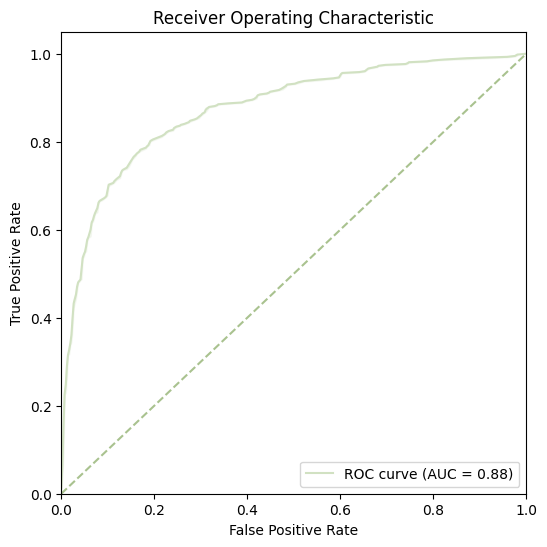

In [13]:
probs = LR_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

auc_score = roc_auc_score(y_test, probs)

plt.figure(figsize=(6, 6))
sns.lineplot(x=fpr, y=tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [14]:
print("Confusion Matrix:\n", conf_matrix)
print("AUC=0.88")

Confusion Matrix:
 [[354  58]
 [127 365]]
AUC=0.88


#### Decision Tree:

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       412
           1       0.79      0.77      0.78       492

    accuracy                           0.76       904
   macro avg       0.76      0.76      0.76       904
weighted avg       0.76      0.76      0.76       904



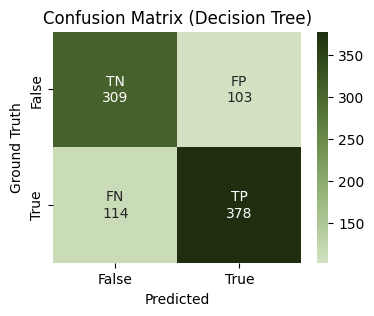

In [15]:
# Initialize the Decision Tree model
DT_model = DecisionTreeClassifier()

# Fit the DT_model on the training data
DT_model.fit(X_train, y_train)

# Make predictions on the testing data
predictions = DT_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, predictions))

conf_matrix = confusion_matrix(y_test, predictions)

labels = ['TN', 'FP', 'FN', 'TP']
labels = np.asarray(labels).reshape(2,2)

labels_val = (np.asarray(["{0}\n{1}".format(label, val) for label, val in zip(labels.flatten(), conf_matrix.flatten())])).reshape(2,2)

plt.figure(figsize=(4,3))
sns.heatmap(conf_matrix, annot=labels_val, fmt='', cmap=CON_CMAP)
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix (Decision Tree)")

plt.xticks([0.5, 1.5], ['False', 'True'])
plt.yticks([0.5, 1.5], ['False', 'True'])

plt.show()


##### ROC-AUC Plot:

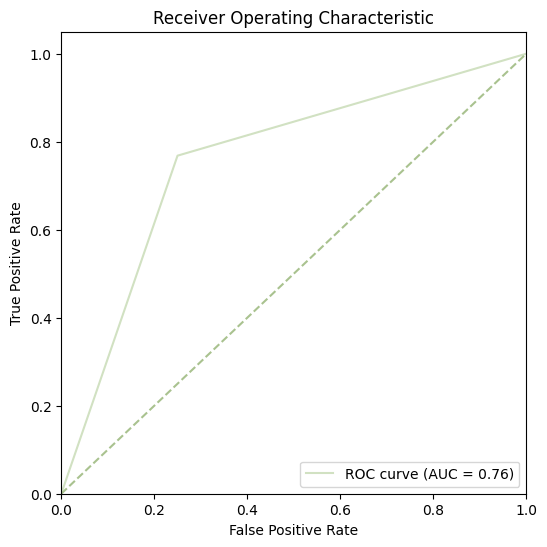

In [16]:
probs = DT_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

auc_score = roc_auc_score(y_test, probs)

plt.figure(figsize=(6, 6))
sns.lineplot(x=fpr, y=tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [17]:
print("Confusion Matrix:\n", conf_matrix)
print("AUC=0.88")

Confusion Matrix:
 [[309 103]
 [114 378]]
AUC=0.88


#### Random Forest:

              precision    recall  f1-score   support

           0       0.79      0.80      0.80       412
           1       0.83      0.83      0.83       492

    accuracy                           0.81       904
   macro avg       0.81      0.81      0.81       904
weighted avg       0.81      0.81      0.81       904



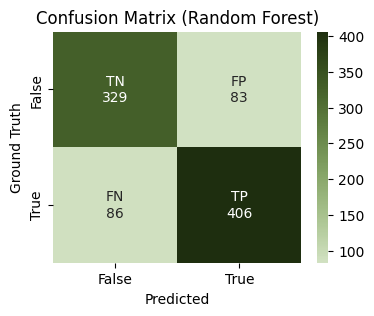

In [18]:
# Initialize the Random Forest model
RF_model = RandomForestClassifier()

# Fit the RF_model on the training data
RF_model.fit(X_train, y_train)

# Make predictions on the testing data
predictions = RF_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, predictions))

conf_matrix = confusion_matrix(y_test, predictions)

labels = ['TN', 'FP', 'FN', 'TP']
labels = np.asarray(labels).reshape(2,2)

labels_val = (np.asarray(["{0}\n{1}".format(label, val) for label, val in zip(labels.flatten(), conf_matrix.flatten())])).reshape(2,2)

plt.figure(figsize=(4,3))
sns.heatmap(conf_matrix, annot=labels_val, fmt='', cmap=CON_CMAP)
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix (Random Forest)")

plt.xticks([0.5, 1.5], ['False', 'True'])
plt.yticks([0.5, 1.5], ['False', 'True'])

plt.show()


##### ROC-AUC Plot:

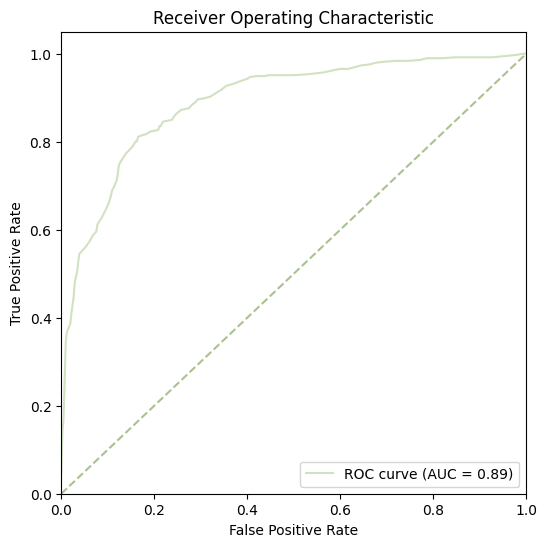

In [19]:
probs = RF_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

auc_score = roc_auc_score(y_test, probs)

plt.figure(figsize=(6, 6))
sns.lineplot(x=fpr, y=tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [20]:
print("Confusion Matrix:\n", conf_matrix)
print("AUC=0.88")

Confusion Matrix:
 [[329  83]
 [ 86 406]]
AUC=0.88


#### XGBoost:

              precision    recall  f1-score   support

           0       0.77      0.80      0.79       412
           1       0.83      0.80      0.82       492

    accuracy                           0.80       904
   macro avg       0.80      0.80      0.80       904
weighted avg       0.80      0.80      0.80       904



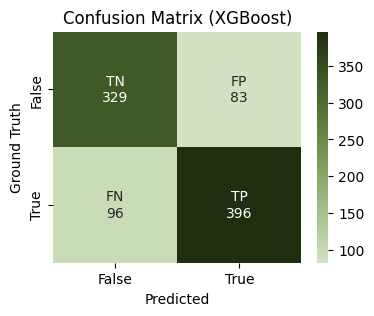

In [21]:
# Initialize the XGBoost model
XGB_model = XGBClassifier(use_label_encoder=False)

# Fit the XGB_model on the training data
XGB_model.fit(X_train, y_train)

# Make predictions on the testing data
predictions = XGB_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, predictions))

conf_matrix = confusion_matrix(y_test, predictions)

labels = ['TN', 'FP', 'FN', 'TP']
labels = np.asarray(labels).reshape(2,2)

labels_val = (np.asarray(["{0}\n{1}".format(label, val) for label, val in zip(labels.flatten(), conf_matrix.flatten())])).reshape(2,2)

plt.figure(figsize=(4,3))
sns.heatmap(conf_matrix, annot=labels_val, fmt='', cmap=CON_CMAP)
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.title("Confusion Matrix (XGBoost)")

plt.xticks([0.5, 1.5], ['False', 'True'])
plt.yticks([0.5, 1.5], ['False', 'True'])

plt.show()


##### ROC-AUC Plot:

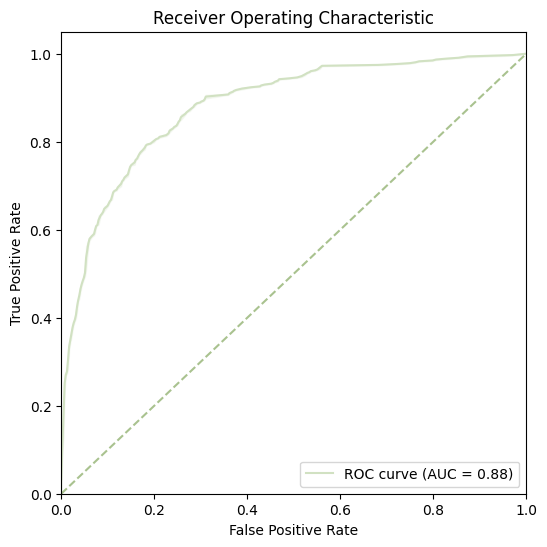

In [22]:
probs = XGB_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

auc_score = roc_auc_score(y_test, probs)

plt.figure(figsize=(6, 6))
sns.lineplot(x=fpr, y=tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [23]:
print("Confusion Matrix:\n", conf_matrix)
print("AUC=0.88")

Confusion Matrix:
 [[329  83]
 [ 96 396]]
AUC=0.88


#### Saving All Models:

In [24]:
dump(LR_model, './models/logistic_regression_model.joblib')
dump(DT_model, './models/decision_tree_model.joblib')
dump(RF_model, './models/random_forest_model.joblib')
dump(XGB_model, './models/xgboost_model.joblib')

['./models/xgboost_model.joblib']